# Imports

In [4]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.utils import shuffle
from helper_functions import data_loading, color_plot, random_sampling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading

In [5]:
stocks_features = data_loading('cwt', 0.75)

In [11]:
feature_matrix = stocks_features['adnc']['feature_matrix']
train_array, test_array = random_sampling(feature_matrix, 0.6)

# Visualization

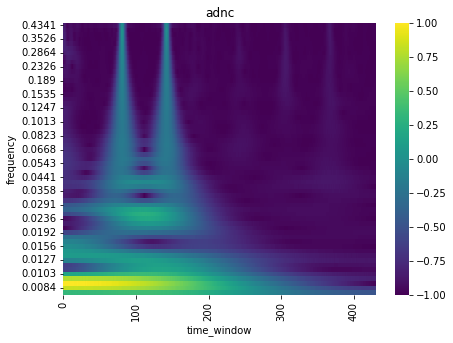

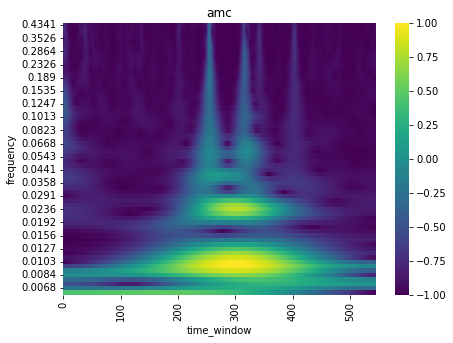

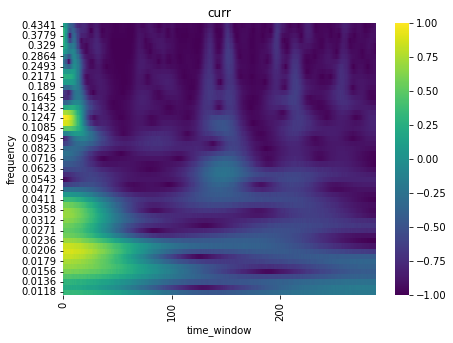

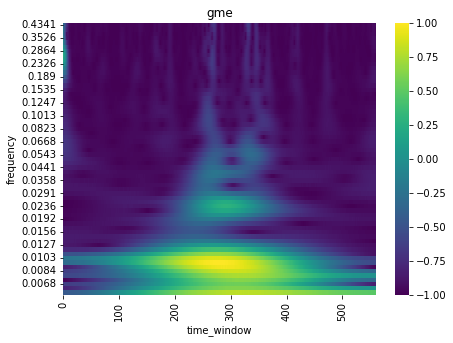

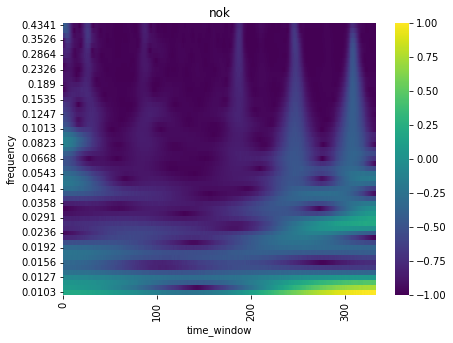

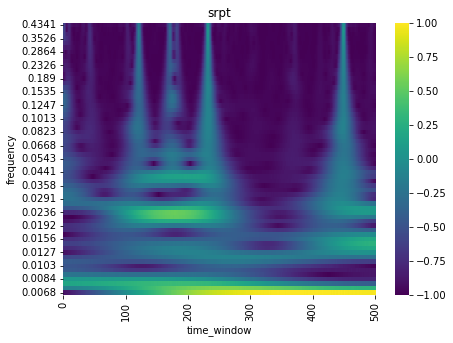

In [77]:
for stock in stocks_features.keys():

    stock_feature_matrix = stocks_features[stock]['feature_matrix'].copy()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    color_plot(stock_feature_matrix, 4, stock, ax)

In [65]:
np.array(stock_cone_of_influence.tolist()*2).reshape()

ValueError: maximum supported dimension for an ndarray is 32, found 1002

In [109]:
stock_df = stocks_dict['adnc'].copy()

# Get conne of influence
cone_of_influence = stock_df.iloc[0, :-1].astype(float)
stock_df.drop(index=[0], inplace=True)

# Get frequencies
frequencies = stock_df.iloc[:, -1].astype(float)
stock_df.drop(columns=['freq'], inplace=True)

# Check if frequencies are repeated
if frequencies.unique().shape[0] != frequencies.shape[0]:
    frequencies = frequencies.to_frame().reset_index()

frequencies = frequencies.to_numpy()

# Convert dataframe to array, and convert array into complex
stock_array = stock_df.to_numpy().astype(str)
stock_array = np.char.replace(stock_array,'i','j')
stock_array = np.char.replace(stock_array,' ','')
stock_array = stock_array.astype(np.complex128)

# Get real and imaginary coefficients
real_coefficients = np.real(stock_array)
imag_coefficients = np.imag(stock_array)

# Map frequencies to coefficients
sample_list = []

for i_freq in range(frequencies.shape[0]):
    for j_time in range(real_coefficients.shape[1]):
        sample = np.array([frequencies[i_freq], real_coefficients[i_freq, j_time], imag_coefficients[i_freq, j_time]])
        sample_list.append(sample)

stock_feature_matrix = np.stack(sample_list)

In [107]:
real_coefficients.shape, imag_coefficients.shape, frequencies.shape

((59, 430), (59, 430), (59,))

(25370, 3)

In [5]:
stocks_dict['adnc']['stf_spectogram']

,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,freq
0,2.0498 + 0.0000i,5.5527 + 0.0000i,4.1448 + 0.0000i,1.7926 + 0.0000i,1.7292 + 0.0000i,1.7463 + 0.0000i,1.8886 + 0.0000i,0.0000
1,0.5915 - 1.6932i,1.4713 - 4.9145i,2.3026 - 3.0329i,0.6548 - 1.4702i,0.6347 - 1.4129i,0.6192 - 1.4353i,0.6918 - 1.5603i,0.0245
2,-0.8871 - 0.7559i,-3.3730 - 2.2295i,-0.6850 - 2.8983i,-0.7721 - 0.8543i,-0.7299 - 0.8218i,-0.7582 - 0.8056i,-0.8420 - 0.9206i,0.0491
3,-0.4736 + 0.1602i,-2.1189 + 1.7002i,-1.7762 - 1.0563i,-0.5975 + 0.2024i,-0.5631 + 0.1765i,-0.5550 + 0.1969i,-0.6710 + 0.2397i,0.0736
4,-0.1729 + 0.0869i,0.4498 + 1.4986i,-1.3776 + 0.2776i,-0.0097 + 0.2409i,-0.0246 + 0.2108i,-0.0228 + 0.2041i,-0.0016 + 0.2916i,0.0982
...,...,...,...,...,...,...,...,...
124,-0.0065 - 0.0104i,0.0431 + 0.0010i,0.0152 + 0.0488i,-0.0017 + 0.0003i,4.4396e-04 - 9.5597e-05i,0.0006 + 0.0013i,-0.0005 + 0.0029i,3.0434
125,-0.0075 + 0.0097i,0.0284 - 0.0283i,0.0557 + 0.0118i,0.0020 + 0.0021i,0.0031 + 0.0005i,0.0035 + 0.0000i,0.0038 + 0.0013i,3.0680
126,0.0097 + 0.0039i,0.0031 - 0.0378i,0.0367 - 0.0415i,0.0023 - 0.0010i,0.0016 - 0.0024i,0.0003 - 0.0022i,0.0008 - 0.0013i,3.0925
127,0.0011 - 0.0092i,-0.0252 - 0.0313i,-0.0180 - 0.0450i,5.2678e-04 - 8.8125e-05i,-2.6696e-04 + 5.1253e-05i,-0.0000 + 0.0020i,0.0010 + 0.0028i,3.1170
